In [109]:
import csv
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
#from sklearn import preprocessing
%matplotlib inline

import seaborn as sb
#%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['figure.figsize'] = (20, 12) #16,9
plt.style.use('ggplot')
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

def leer_datos(nombre_archivo):
    """ Recupera los datos a partir del archivo provisto.
        
        Pre: el archivo contiene los ...
        Post: la lista devuelta contiene ... en el formato:
        [....].
    """
    
    datos = []
    datos = pd.read_csv(nombre_archivo,encoding='ISO-8859-1')
    return datos

def boxplot_variables_estandarizadas(datos):
    from sklearn import preprocessing
    """ Para analizar las variables dependientes de la demanda 
        de gas natural por subsector, se utilizó uan grafica de
        cajas. 
        Las variables analizadas son:
            demanda, pib, precio_combu, y precio_gas.
        Para poder realizar la comparación entre las variables,
        se estandarizaron los datos.
    """
    df = pd.DataFrame(datos.loc[(datos['Anio'] <= 2015)], \
                      columns=['Demanda','Precio_gas_natural','Precio_combustoleo','PIB'])
    df['PIB'] = df.PIB.astype(float)

    float_array = df.drop_duplicates()

    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
    scaled_array = min_max_scaler.fit_transform(float_array)
    scaled_array
    df_normalized = pd.DataFrame(scaled_array,columns=['Demanda','Precio_gas_natural','Precio_combustoleo','PIB'])
    #print(df_normalized.head())
    print(df_normalized.describe())
    
    boxplot = df_normalized.boxplot(column=['Demanda','Precio_gas_natural','Precio_combustoleo','PIB'])
    boxplot.set_title("Boxplot de variables estandarizadas")
    
    boxplot.figure.savefig('boxplot_variables_estandarizadas.png', bbox_inches='tight')


def plot_demanda_gas_natural_subsector(datos):
    """ Para presentar la demanda de gas natural por subsector, 
        se utilizó una gráfica de líneas que compara todos los 
        sectores.
    """
    df = pd.DataFrame(datos.loc[(datos['Anio'] <= 2015)],columns=['Rama','Anio','Demanda'])
    #print('plot_demanda_gas_natural_subsector')
    
    fig, ax = plt.subplots(figsize=(10,10))
    
    lines = df.groupby(['Anio','Rama'])['Demanda'].sum()
    #print(lines.unstack().head())
    plot_df = lines.unstack().plot(kind='line',stacked=True, \
                                   title="Demanda de gas natural por subsector",figsize=(15,10), \
                                   ax=ax)
    ax.set_xlabel('Año')
    ax.set_ylabel('Demanda')
    
    plt.show()
    
    fig.savefig('plot_demanda_gas_natural_subsector.png', bbox_inches='tight', dpi=1000)

def calc_timeseries(datos):
    """ Se muestra por sector los datos registrados en forma periódica que 
        muestran la demanda de gas natural con datos estandarizados.
    """
    datos.set_index('Rama', inplace = True)
    
    ramas = ['Alimentos','Celulosa y papel','Cemento y vidrio','Cerveza y malta', \
             'Metales básicos','Minería y Productos metálicos, equipo eléctrico y de transporte' \
             ,'Productos de minerales no metálicos','Química','Resto','Textil']

    i=0
    fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(8,47))
    for rama in ramas:
        traindf=pd.DataFrame(datos.loc[rama])
        traindf['Fecha']=pd.to_datetime('01-01-'+traindf['Anio'].astype(str), format='%d-%m-%Y')
        cols = traindf.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        traindf = traindf[cols]
        traindf.set_index(pd.DatetimeIndex(traindf['Fecha']), inplace = True)
        traindf.drop(['Fecha'], axis=1, inplace=True)

        subset = pd.DataFrame(traindf.loc['2005-01-01 00:00:00':'2030-12-01 23:00:00','Demanda'])

        subset.plot(ax=axes[i]); axes[i].set_title(rama)
        axes[i].set_ylabel('Demanda')
        #fig=axes[i].get_figure()
        #fig.savefig('plot.png')
        i=i+1
    plt.tight_layout()
    plt.show()
    
    #fig.savefig('plot_timeseries.png', bbox_inches='tight', dpi=1000)
    

def calc_regresion_lineal(datos):
    """
        Los métodos de regresión se usan para estudiar la relación entre dos
        variables numéricas.
        
        Esta relación permitirá en el futuro, medir una muestra desconocida
        y conocer aproximadamente su verdadero valor.
    """
    # Organización de datos necesarios
    datos.set_index('Rama', inplace = True)
    datos_lagged=lagged_dataframe(datos.loc['Alimentos'], lags=1)
    datos_lagged.fillna(0, inplace = True)
    
    dataX = datos_lagged[["PIB"]]
    X_train = np.array(dataX)
    #print(X_train.head())
    y_train = datos_lagged['Demanda'].values #datos_lagged['Demanda']    
    
    # Creamos el objeto de Regresión Linear
    regr = linear_model.LinearRegression()
    
    # Entrenamos nuestro modelo
    regr.fit(X_train, y_train)
    
    # Hacemos las predicciones que en definitiva una línea (en este caso, al ser 2D)
    y_pred = regr.predict(X_train)

    # Veamos los coeficienetes obtenidos, En nuestro caso, serán la Tangente
    print('Coefficients: \n', regr.coef_)
    # Este es el valor donde corta el eje Y (en X=0)
    print('Independent term: \n', regr.intercept_)
    # Error Cuadrado Medio
    print("Mean squared error: %.2f" % mean_squared_error(y_train, y_pred))
    # Puntaje de Varianza. El mejor puntaje es un 1.0
    print('Variance score: %.2f' % r2_score(y_train, y_pred))
    
    #plt.scatter(X_train[:,0], y_train,  c=asignar, s=tamanios[0])
    tamanios=[30,60]
    plt.scatter(X_train[:,0], y_train, color='blue', s=tamanios[0])
    plt.plot(X_train[:,0], y_pred, color='red', linewidth=3)

    #plt.xlabel('Anio')
    plt.xlabel('PIB')
    plt.ylabel('Demanda')
    plt.title('Regresión Lineal')
    
    fig = plt.gcf()
    plt.show()
    
    #fig.savefig("calc_regresion_lineal.png")
    
    # Vamos a comprobar:
    # Quiero predecir la demanda de gas natural para el PIB,
    # según nuestro modelo, hacemos:
    y_predict = regr.predict([[720]])
    print("La predicción de la demanda de gas natural cuando el PIB es 720 es:",int(y_predict))

def calc_regresion_lineal_multiple(datos):
    """
        Los métodos de regresión se usan para estudiar la relación entre dos
        variables numéricas.
        
        Esta relación permitirá en el futuro, medir una muestra desconocida
        y conocer aproximadamente su verdadero valor.
    """
    # Vamos a intentar mejorar el Modelo, con más dimensiones: 
    # Para poder graficar en 3D, haremos una variable nueva que será la suma de variables
    suma = ( datos['Precio_combustoleo'] \
            + datos['Precio_gas_natural'])
    
    dataX2 =  pd.DataFrame()
    dataX2['PIB'] = datos['PIB'].fillna(0)
    dataX2['suma'] = suma
    XY_train = np.array(dataX2)
    #print(XY_train)
    z_train = datos['Demanda'].values
    
    # Creamos un nuevo objeto de Regresión Lineal
    regr2 = linear_model.LinearRegression()

    # Entrenamos el modelo, esta vez, con 2 dimensiones
    # obtendremos 2 coeficientes, para graficar un plano
    regr2.fit(XY_train, z_train)

    # Hacemos la predicción con la que tendremos puntos sobre el plano hallado
    z_pred = regr2.predict(XY_train)

    # Los coeficientes
    print('Coefficients: \n', regr2.coef_)
    # Error cuadrático medio
    print("Mean squared error: %.2f" % mean_squared_error(z_train, z_pred))
    # Evaluamos el puntaje de varianza (siendo 1.0 el mejor posible)
    print('Variance score: %.2f' % r2_score(z_train, z_pred))
    
    fig = plt.figure()
    ax = Axes3D(fig)
    
    # Creamos una malla, sobre la cual graficaremos el plano
    xx, yy = np.meshgrid(np.linspace(0, 3500, num=10), np.linspace(0, 60, num=10))
    
    # calculamos los valores del plano para los puntos x e y
    nuevoX = (regr2.coef_[0] * xx)
    nuevoY = (regr2.coef_[1] * yy) 
    
    # calculamos los correspondientes valores para z. Debemos sumar el punto de intercepción
    z = (nuevoX + nuevoY + regr2.intercept_)
    
    # Graficamos el plano
    ax.plot_surface(xx, yy, z, alpha=0.2, cmap='hot')
    
    # Graficamos en azul los puntos en 3D
    ax.scatter(XY_train[:, 0], XY_train[:, 1], z_train, c='blue',s=30)
    
    # Graficamos en rojo, los puntos que 
    ax.scatter(XY_train[:, 0], XY_train[:, 1], z_pred, c='red',s=40)
    
    # con esto situamos la "camara" con la que visualizamos
    ax.view_init(elev=30., azim=65)
    
    ax.set_xlabel('PIB')
    ax.set_ylabel('Precio_combustoleo, Precio_gas_natural')
    ax.set_zlabel('Demanda')
    ax.set_title('Regresión Lineal con Múltiples Variables')
    
    #plt.savefig("calc_regresion_lineal_multiple.png")
    
    # Si quiero predecir la "Demanda" cuando: 
    # el PIB es: 392, el precio de gas natural: 10, precio de combustoleo: 15
    # según nuestro modelo, obtendíamos:
 
    z_PredDemanda = regr2.predict([[392, 10+15]])
    print("Predicción de la demanda cuándo el PIB es: 720, el precio de gas natural: 8, precio de combustoleo: 17")
    print("obtendríamos: ",int(z_PredDemanda))
    
    
def histograma(datos):
    """ 
        Se utilizaron histogramas para estudiar las variables por sector,
        los cuáles representan los datos de entrada para el análisis.
    """
    # Visualizamos rápidamente las caraterísticas de entrada
    datos.set_index('Rama', inplace = True)
    #print(datos_lagged.head())
                           
    sector=pd.DataFrame(datos.loc['Alimentos',['Demanda','Precio_gas_natural','Precio_combustoleo','PIB']])
    sector.fillna(0, inplace = True)
  
    fig=plt.gcf()

    sector.hist()
    plt.suptitle("Histograma")
    
    #plt.savefig('histograma.png', format='png', bbox_inches='tight', dpi=640)
    plt.show()
    

def relacion_entre_variables(datos):
    """
       Esta función presenta a través del uso de una gráfica scatter plot la relación
       entre los pares de las posbiles variables. Es decir se identifica si  
       la relación entre las variables es efectivamente directa.
    """
    sb.set()
    
    datos_lagged=lagged_dataframe(datos, lags=1)
    datos_lagged.set_index('Rama', inplace = True)
    
    traindf=pd.DataFrame(datos_lagged.loc['Alimentos',['Demanda','Demanda_lag','PIB', \
                                                       'Precio_combustoleo','Precio_gas_natural']])
    print(traindf.head())
    
    fig=plt.figure()

    ax = sb.pairplot(traindf, height=2.5);
    ax.fig.suptitle("Relación entre las variables")
    
    #fig = ax.get_figure()
    plt.show()
    
    #ax.savefig("relacion_entre_variables.png")

def correlacion_entre_variables(datos):
    """ 
       La finalidad de la correlación es examinar la dirección y la fuerza de 
       la asociación entre dos variables cuantitativas. Así conoceremos 
       la intensidad de la relación entre ellas y si, al aumentar el valor 
       de una variable, aumenta o disminuye el valor de la otra variable. 
    """
    plt.rcParams['figure.figsize'] = (10, 16) #16,9
    plt.style.use('ggplot')
    
    #print('inicio')
    
    datos_lagged=lagged_dataframe(datos.loc[(datos['Anio'] <= 2015)], lags=1)
    datos_lagged.set_index('Rama', inplace = True)
    #print(datos_lagged.head())
                           
    traindf=pd.DataFrame(datos_lagged.loc['Alimentos',['Demanda','Precio_gas_natural','Precio_combustoleo','PIB','Demanda_lag','Precio_gas_natural_lag','Precio_combustoleo_lag','PIB_lag']])
    traindf.fillna(0, inplace = True)
    
    plt.matshow(traindf.corr().round(2))
    plt.xticks(range(len(traindf.columns)), traindf.columns)
    plt.yticks(range(len(traindf.columns)), traindf.columns)
    plt.colorbar()
    plt.title('Correlación de variables')
    #plt.figure(figsize=(50,50))
    fig=plt.gcf()
    
    plt.show()
    plt.draw()
    
    #fig.savefig("correlacion_entre_variables.png", format='png', bbox_inches='tight', dpi=640)
     
def lagged_dataframe(df, lags=1):
    data_frames = [df]
    
    df = df.assign(Demanda_lag=df.Demanda.shift(lags))
    df = df.assign(PIB_lag=df.PIB.shift(lags))
    df = df.assign(Precio_combustoleo_lag=df.Precio_combustoleo.shift(lags))
    df = df.assign(Precio_gas_natural_lag=df.Precio_gas_natural.shift(lags))
    df.fillna(0, inplace = True)
    
    return df
    
def main():
    dirname = r'C:\tempR\SENER_2\gas_natural.csv'
    filname = dirname #+ '\' + "gas_natural.csv"

    datos = leer_datos(filname)
    #print(datos.dtypes)
    datos_lagged=lagged_dataframe(datos, lags=1)
    #print(datos_lagged.head())

    #print('Paso 1')
    #plot_demanda_gas_natural_subsector(datos)
    #print('Paso 2')
    #boxplot_variables_estandarizadas(datos)
    #print('Paso 3')
    #calc_timeseries(datos)
    #print('Paso 3.1')
    #histograma(datos)
    #print('Paso 4')
    #relacion_entre_variables(datos)
    #print('Paso 5')
    #correlacion_entre_variables(datos)
    #print('Paso 6')
    #calc_regresion_lineal(datos)
    #print('Paso 7')
    #calc_regresion_lineal_multiple(datos_lagged)
    

In [110]:
main()

In [111]:
dirname      = r'C:\tempR\SENER_2\gas_natural.csv'
filname      = dirname #+ '\' + "gas_natural.csv"
datos        = leer_datos(filname)
datos_lagged =lagged_dataframe(datos, lags=1)

Paso 1


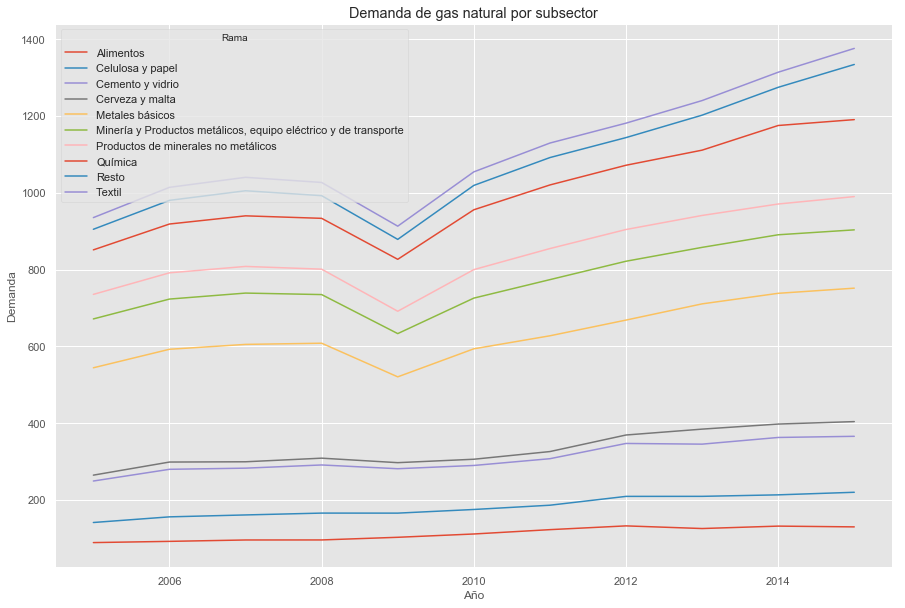

In [112]:
print('Paso 1')
plot_demanda_gas_natural_subsector(datos)

Paso 2
          Demanda  Precio_gas_natural  Precio_combustoleo         PIB
count  110.000000          110.000000          110.000000  110.000000
mean     0.288519            0.409949            0.589723    0.210193
std      0.233719            0.286328            0.346323    0.266775
min      0.000000            0.000000            0.000000    0.000000
25%      0.140394            0.207547            0.252174    0.064111
50%      0.237278            0.339623            0.573913    0.077003
75%      0.359831            0.622642            0.921739    0.304704
max      1.000000            1.000000            1.000000    1.000000


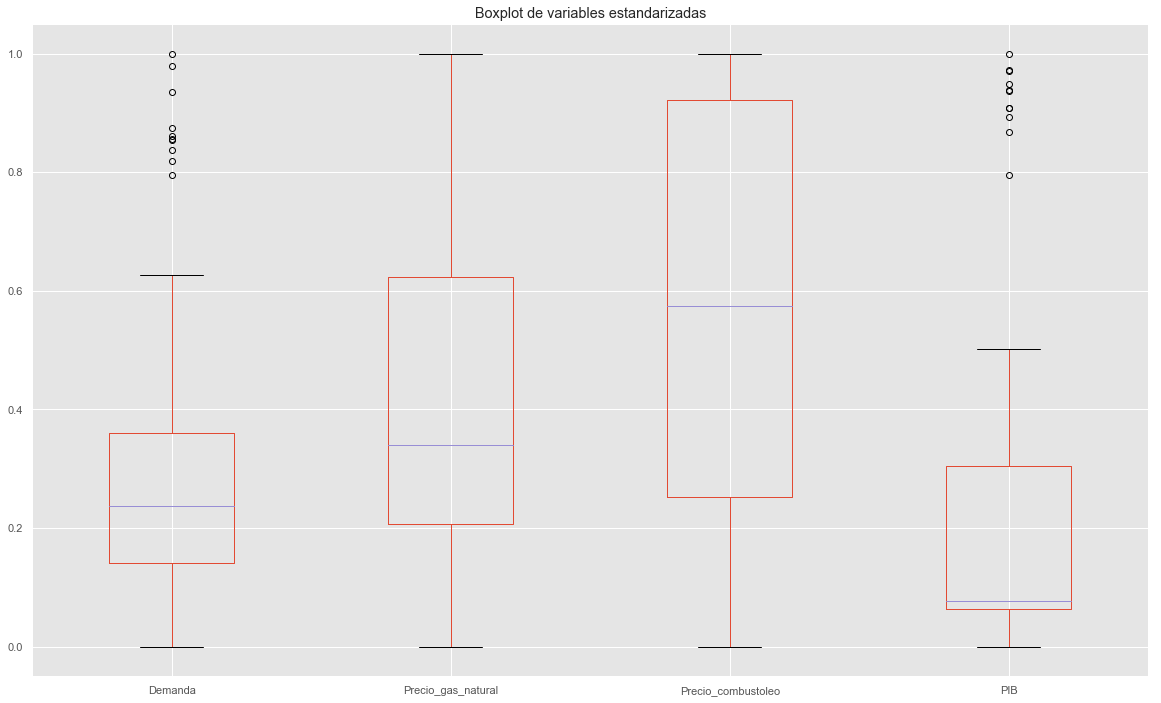

In [113]:
print('Paso 2')
boxplot_variables_estandarizadas(datos)

Paso 3.1


<Figure size 1440x864 with 0 Axes>

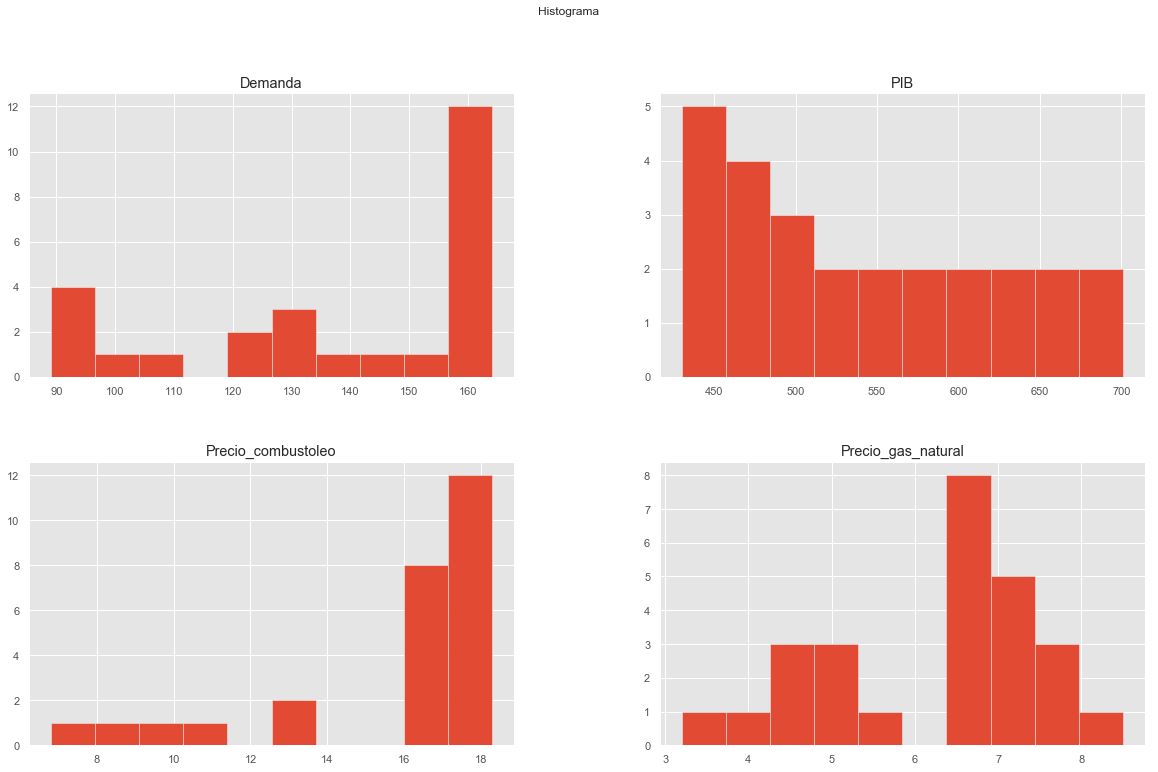

In [114]:
print('Paso 3.1')
#datos        = leer_datos(filname)
histograma(datos)

Paso 3


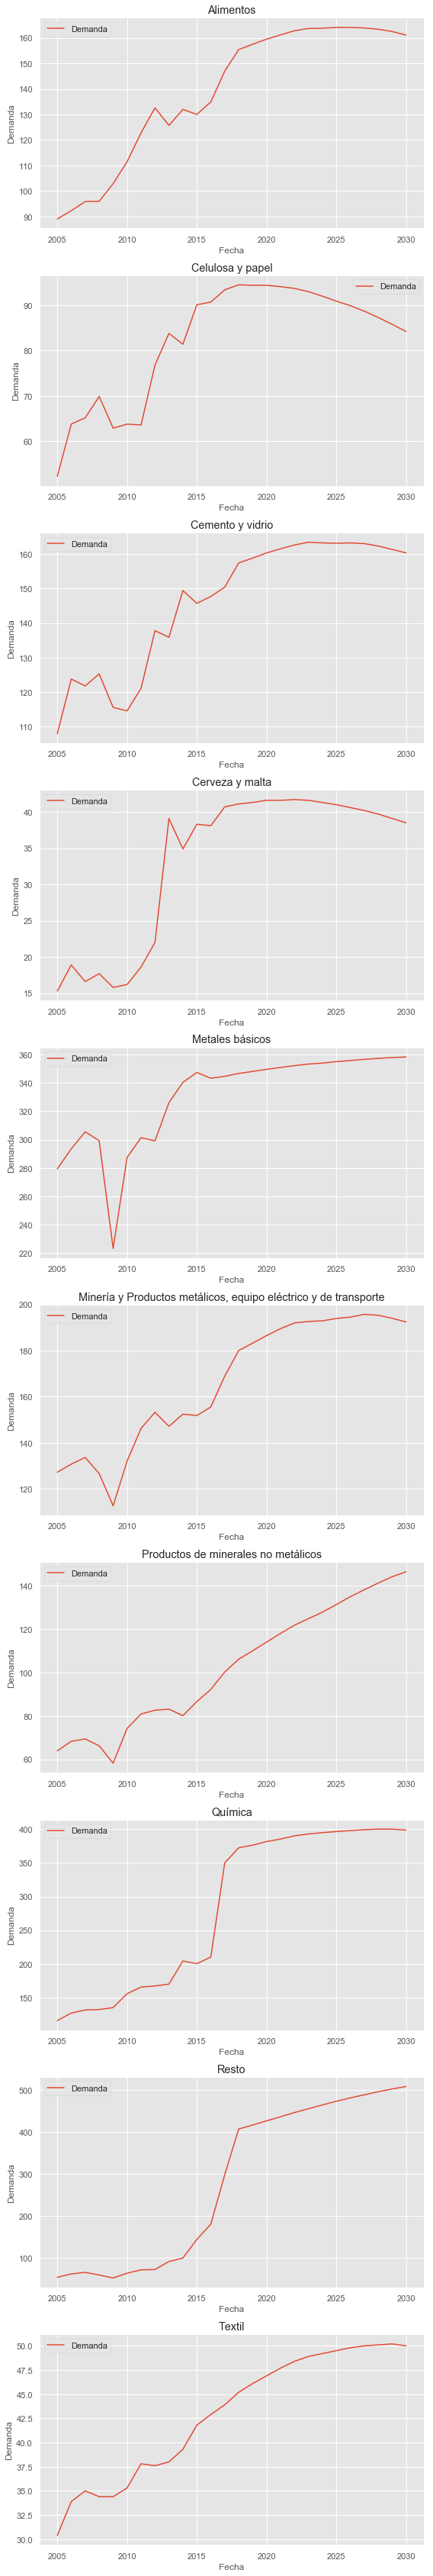

In [115]:
print('Paso 3')
datos        = leer_datos(filname)
calc_timeseries(datos)

Paso 4
           Demanda  Demanda_lag  PIB  Precio_combustoleo  Precio_gas_natural
Rama                                                                        
Alimentos     89.1          0.0  430                 6.8                 7.1
Alimentos     92.3         89.1  437                 8.7                 6.5
Alimentos     95.9         92.3  447                 9.7                 6.4
Alimentos     96.0         95.9  451                13.0                 8.5
Alimentos    102.9         96.0  450                10.4                 3.8


<Figure size 1440x864 with 0 Axes>

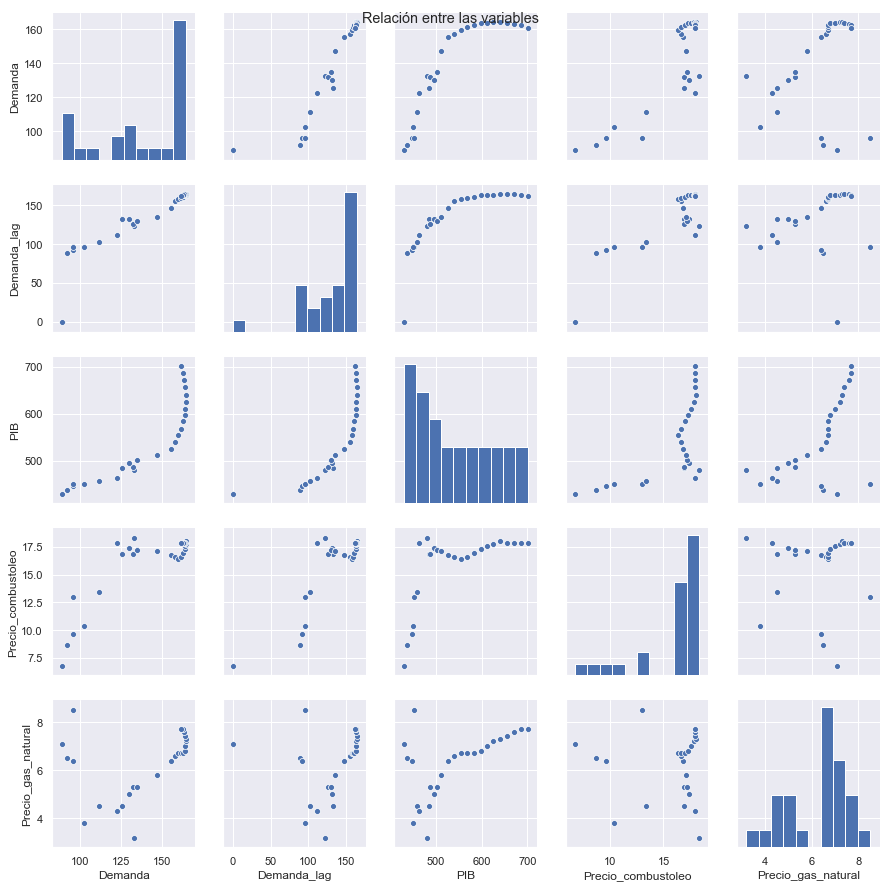

In [116]:
datos = leer_datos(filname)
print('Paso 4')
relacion_entre_variables(datos)

Paso 5


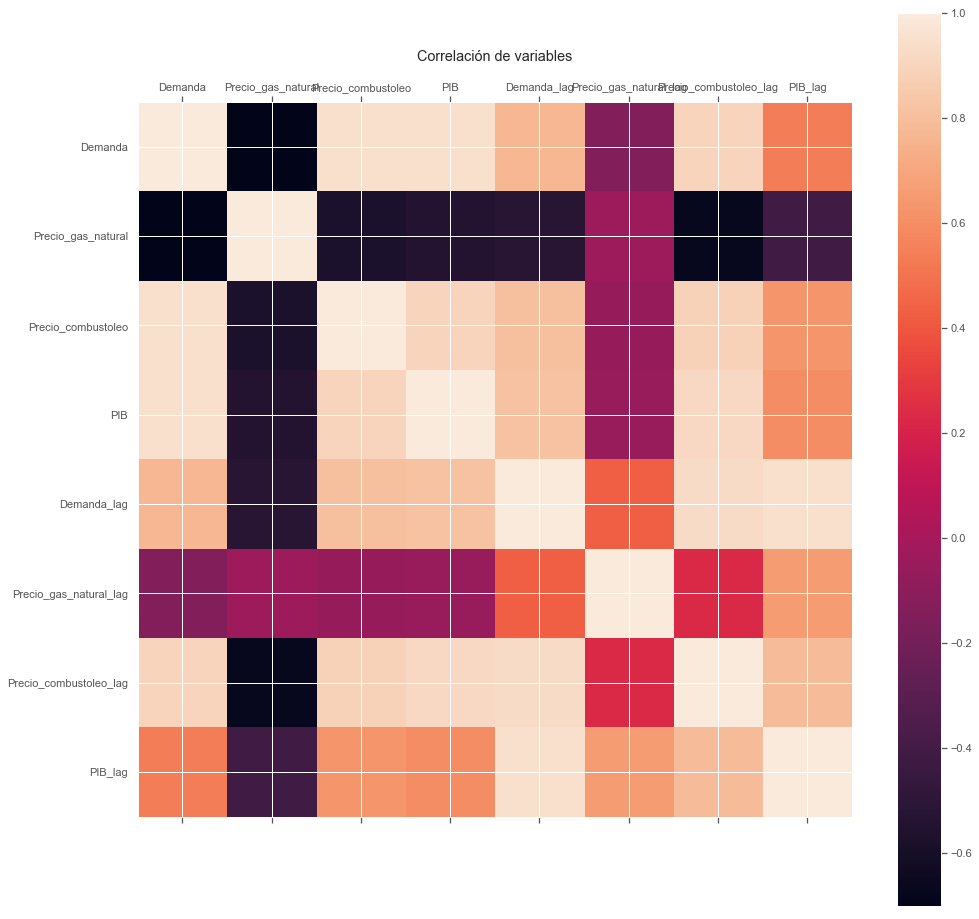

<Figure size 720x1152 with 0 Axes>

In [117]:
print('Paso 5')
datos = leer_datos(filname)
correlacion_entre_variables(datos)

Paso 6
Coefficients: 
 [0.27358057]
Independent term: 
 -8.8364793788719
Mean squared error: 171.40
Variance score: 0.75


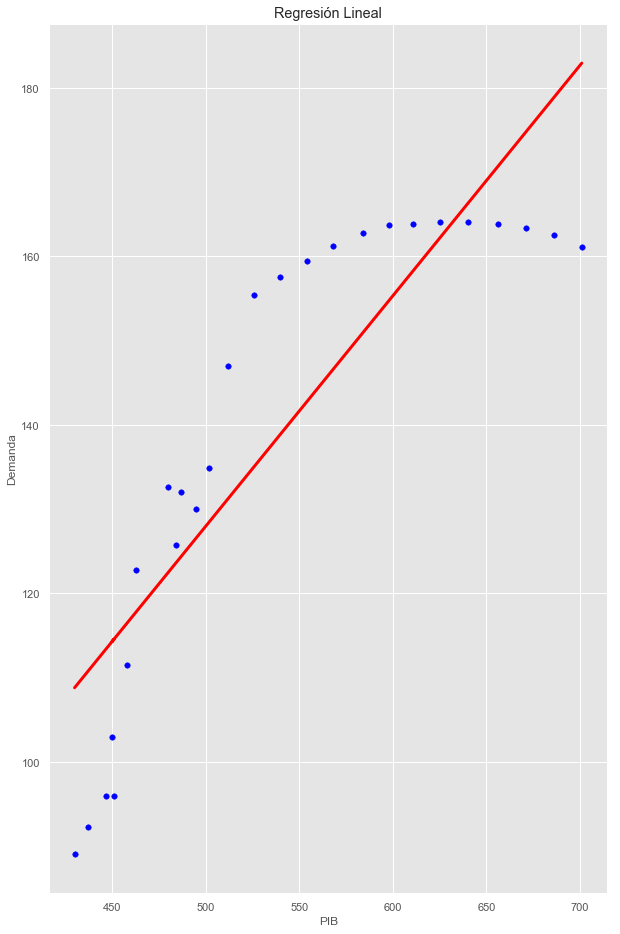

La predicción de la demanda de gas natural cuando el PIB es 720 es: 188


In [118]:
print('Paso 6')
datos = leer_datos(filname)
calc_regresion_lineal(datos)

Paso 7
Coefficients: 
 [0.10958493 8.97368487]
Mean squared error: 10752.27
Variance score: 0.29
Predicción de la demanda cuándo el PIB es: 720, el precio de gas natural: 8, precio de combustoleo: 17
obtendríamos:  187


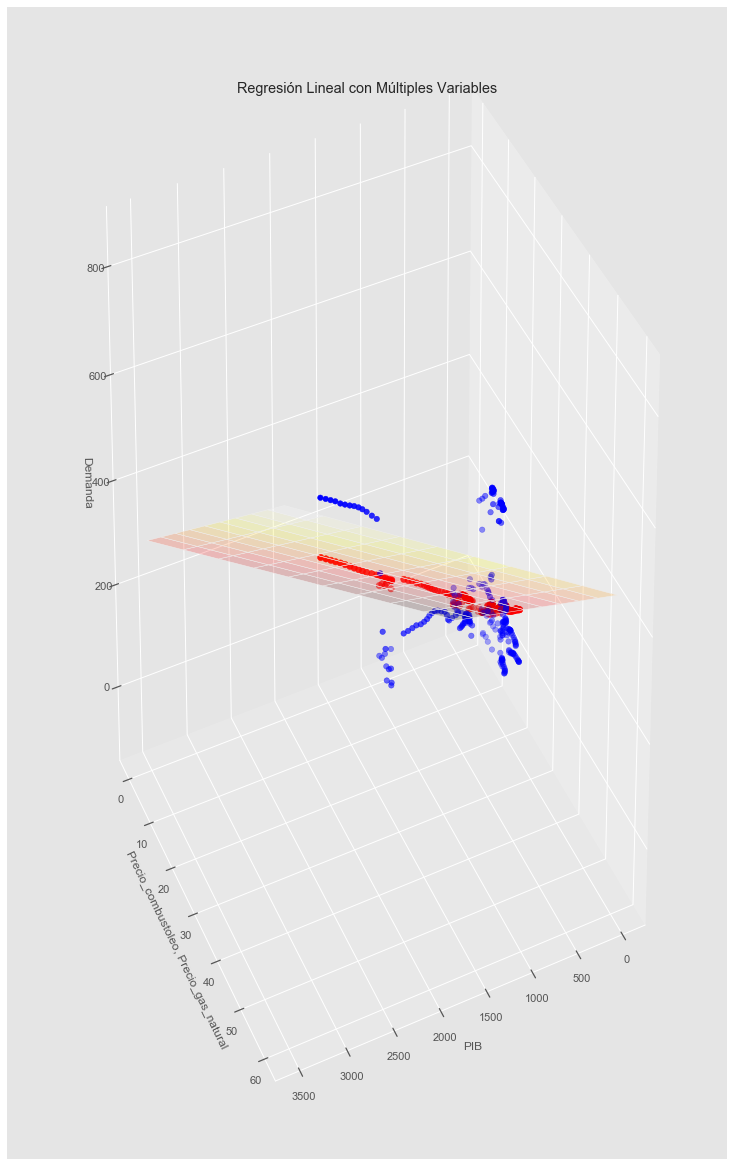

In [119]:
print('Paso 7')
calc_regresion_lineal_multiple(datos_lagged)